In [99]:
from datasets import load_dataset
from huggingface_hub import login
import tiktoken
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
# import statsmodels.stats.proportion as smp
from concurrent.futures import ProcessPoolExecutor
from scipy import stats

In [100]:
def safe_convert_to_float(value):
    """
    Safely convert a value to float, handling various formats.
    
    Args:
        value: Value to convert (string, int, float, etc.)
        
    Returns:
        float: Converted value or NaN if conversion fails
    """
    if value is None:
        return float('nan')
    
    if isinstance(value, (int, float)):
        return float(value)
    
    if isinstance(value, str):
        # Clean up the string if it has ellipsis or other non-numeric characters
        clean_value = value.strip()
        
        # Handle ellipsis
        if '...' in clean_value:
            clean_value = clean_value.split('...')[0]
        
        # Remove trailing decimal point if present
        if clean_value.endswith('.'):
            clean_value = clean_value[:-1]
        
        # Handle potential multiple decimal points (like "10.4.")
        parts = clean_value.split('.')
        if len(parts) > 2:
            clean_value = parts[0] + '.' + parts[1]
        
        try:
            return float(clean_value)
        except ValueError:
            print(f"Warning: Could not convert '{value}' to float. Using NaN instead.")
            return float('nan')
    
    print(f"Warning: Unexpected type {type(value)} for value {value}. Using NaN instead.")
    return float('nan')

def get_nodes(completion):
    result = {
        'nodes': [],
        'states': []
    }
    
    # Get nodes with their available numbers
    node_matches = re.finditer(r"Generated Node #([\d,\.]+): \d+:\[([\d, ]+)\]", completion)
    for match in node_matches:
        result['nodes'].append({
            'node_id': match.group(1),
            'available_nums': [int(n.strip()) for n in match.group(2).split(',') if n.strip()]
        })
    
    return result

def evaluate_and_characterize_failures(trajectory, target, nums, tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")) -> dict:
    """
    Evaluates a countdown task trajectory and returns detailed diagnosis information
    for all error types, plus equation statistics.
    
    Args:
        trajectory (str): The reasoning trajectory text
        target (int/float): The target number to reach
        nums (list): List of starting numbers available
    
    Returns:
        dict: Results containing various error indicators and statistics
    """
    import re
    import ast
    import math
    from typing import List

    # Initialize error flags
    is_valid = True
    arithmetic_error = False
    sign_error = False
    invalid_number_usage = False
    formatting_issues = False
    mismatched_target = False
    no_solution = False
    token_count = len(tokenizer(trajectory)["input_ids"])
    
    # Initialize equation counters
    total_equations = 0
    arithmetic_error_count = 0
    sign_error_count = 0
    
    # Initialize heuristic calculation tracking
    heuristic_calculation_count = 0
    heuristic_arithmetic_errors = 0
    
    # Initialize node tracking
    nodes = get_nodes(trajectory)
    num_nodes = len(nodes['nodes'])
    
    # Enhanced pattern to capture both "=" and "is" as equation separators with flexible spacing
    equation_pattern = re.compile(r"([\d.]+)(?:\.{3})?\s*([\+\-\*/])\s*([\d.]+)(?:\.{3})?\s*(?:=|is)\s*([\d.]+)(?:\.{3})?")
    all_equations = equation_pattern.findall(trajectory)
    
    total_equations = len(all_equations)
    
    # Check each equation for arithmetic correctness and sign errors
    for eq in all_equations:
        try:
            num1 = safe_convert_to_float(eq[0])
            op = eq[1]
            num2 = safe_convert_to_float(eq[2])
            result = safe_convert_to_float(eq[3])
            
            # Calculate the expected result
            if op == '+':
                expected = num1 + num2
            elif op == '-':
                expected = num1 - num2
            elif op == '*':
                expected = num1 * num2
            elif op == '/':
                if math.isclose(num2, 0.0):
                    arithmetic_error_count += 1
                    continue
                expected = num1 / num2
            else:
                # Invalid operator
                continue
                
            # Compare expected vs. given result
            if not math.isclose(expected, result, rel_tol=1e-5):
                arithmetic_error_count += 1
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(expected), abs(result), rel_tol=1e-5) and math.copysign(1, expected) != math.copysign(1, result):
                    sign_error_count += 1
                
        except Exception:
            # Skip equations with parsing issues
            continue
    
    
    
    # Find and validate heuristic score calculations
    # Pattern for simple heuristic count
    heuristic_pattern = re.compile(r"Heuristic score\s*:", re.IGNORECASE)
    heuristic_lines = [m.start() for m in re.finditer(heuristic_pattern, trajectory)]
    heuristic_calculation_count = len(heuristic_lines)
    
    # Detailed pattern for validating the arithmetic in heuristic calculations
    # This is complex and may need tuning based on actual format
    heuristic_calc_pattern = re.compile(
        r"Heuristic score\s*:\s*\((.*?)\)/(\d+)\s*=\s*(.*?)\s*=\s*([\d.]+)", 
        re.IGNORECASE
    )
    
    for match in heuristic_calc_pattern.finditer(trajectory):
        # Extract the parts of the calculation
        expressions_part = match.group(1)  # e.g. "|9-20| + |67-20| + |57-20|"
        divisor = int(match.group(2))      # e.g. 3
        sums_part = match.group(3)         # e.g. "(11 + 47 + 37)"
        claimed_result = safe_convert_to_float(match.group(4))  # e.g. 30.33
        
        # Find individual absolute values in the expression
        abs_values = []
        try:
            # Extract values from sums part (e.g. "11 + 47 + 37")
            terms = re.findall(r'(\d+(?:\.\d+)?)', sums_part)
            abs_values = [safe_convert_to_float(t) for t in terms]
            
            # Calculate expected result
            expected_sum = sum(abs_values)
            expected_result = expected_sum / divisor
            
            # Compare with claimed result
            if not math.isclose(expected_result, claimed_result, rel_tol=1e-2):
                heuristic_arithmetic_errors += 1
        except:
            # If we can't fully parse the heuristic calculation, just count it
            pass
    
    
    # Check for formatting: SOLUTION field
    sol_match = re.search(r"SOLUTION:\s*(YES|NO)", trajectory, re.IGNORECASE)
    if not sol_match:
        formatting_issues = True
        is_valid = False
    else:
        sol_decl = sol_match.group(1).upper()
        no_solution = (sol_decl == "NO")
    
    # Extract OPERATIONS list
    operations = []
    ops_match = re.search(r"OPERATIONS:\s*(\[[^\]]*\])", trajectory, re.DOTALL)
    if not ops_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            operations = ast.literal_eval(ops_match.group(1))
            if not isinstance(operations, list):
                formatting_issues = True
                is_valid = False
        except Exception:
            formatting_issues = True
            is_valid = False    
    
    # Extract final RESULT
    expected_final = None
    res_match = re.search(r"RESULT:\s*([-+.\d]+|None)", trajectory)  # Added 'None' as a valid pattern
    if not res_match:
        formatting_issues = True
        is_valid = False
    else:
        result_str = res_match.group(1)
        if result_str.lower() == "none":
            # This is fine for NO solution cases
            if not no_solution:
                formatting_issues = True  # Only a formatting issue if SOLUTION isn't NO
        else:
            try:
                expected_final = safe_convert_to_float(result_str)
            except Exception:
                formatting_issues = True
                is_valid = False
    
    # Validate consistency between SOLUTION and OPERATIONS/RESULT
    if no_solution:
        # For NO solution: operations should be empty and result should be None
        if operations and operations != []:
            formatting_issues = True  # Having operations with NO solution is a formatting issue
        if expected_final is not None:
            formatting_issues = True  # Having a numeric result with NO solution is a formatting issue
    
    # If we have severe formatting issues, we can't proceed with arithmetic and usage checks
    if formatting_issues or no_solution:
        return {
            # Overall trajectory status
            "is_valid": is_valid,
            "no_solution": no_solution,
            
            # Main error types
            "formatting_issues": formatting_issues,
            "arithmetic_error": arithmetic_error,
            "sign_error": sign_error,
            "invalid_number_usage": invalid_number_usage,
            "mismatched_target": mismatched_target,
            
            # Error counts and statistics
            "arithmetic_error_count": arithmetic_error_count,
            "sign_error_count": sign_error_count,
            "total_equations": total_equations,
            
            # Search process metrics
            "num_nodes": num_nodes,
            "heuristic_calculation_count": heuristic_calculation_count,
            "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
            
            # Resource usage
            "token_count": token_count
        }
    
    # Simulation: available numbers (as floats)
    available = [safe_convert_to_float(n) for n in nums]
    
    # Enhanced operation pattern for validation
    op_pattern = re.compile(r"^\s*([\d.]+(?:\.{3})?)\s*([\+\-\*/])\s*([\d.]+(?:\.{3})?)\s*(?:=|is)\s*([\d.]+(?:\.{3})?)\s*$")
    
    operation_results = []  # Store results to check if all numbers were used
    
    for op_str in operations:
        m = op_pattern.match(op_str)
        if not m:
            formatting_issues = True
            is_valid = False
            continue
        
        op1_str, operator, op2_str, given_result_str = m.groups()
        try:
            op1 = safe_convert_to_float(op1_str)
            op2 = safe_convert_to_float(op2_str)
            op_result = safe_convert_to_float(given_result_str)
        except Exception:
            formatting_issues = True
            is_valid = False
            continue
        
        # Check arithmetic correctness
        try:
            if operator == '+':
                computed = op1 + op2
            elif operator == '-':
                computed = op1 - op2
            elif operator == '*':
                computed = op1 * op2
            elif operator == '/':
                if math.isclose(op2, 0.0):
                    arithmetic_error = True
                    is_valid = False
                    continue
                computed = op1 / op2
            else:
                formatting_issues = True
                is_valid = False
                continue
                
            if not math.isclose(computed, op_result, rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(computed), abs(op_result), rel_tol=1e-5):
                    sign_error_count += 1
                    sign_error = True
        except Exception:
            arithmetic_error = True
            is_valid = False
            continue
        
        operation_results.append((op1, op2, op_result))
    
    # Check for invalid number usage by simulating all operations
    if operation_results:
        try:
            # Reset available numbers for a fresh check
            available = [safe_convert_to_float(n) for n in nums]
            
            def consume(value, pool):
                for i, num in enumerate(pool):
                    if math.isclose(num, value, rel_tol=1e-5):
                        del pool[i]
                        return True
                return False
            
            for op1, op2, result in operation_results:
                if not consume(op1, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                if not consume(op2, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                available.append(result)
            
            # After all operations, should have exactly one number equal to target
            if len(available) != 1:
                invalid_number_usage = True
                is_valid = False
            elif expected_final is not None and not math.isclose(available[0], safe_convert_to_float(target), rel_tol=1e-5):
                mismatched_target = True
                is_valid = False
                
        except Exception:
            invalid_number_usage = True
            is_valid = False
    
    return {
            # Overall trajectory status
            "is_valid": is_valid,
            "no_solution": no_solution,
            
            # Main error types
            "formatting_issues": formatting_issues,
            "arithmetic_error": arithmetic_error,
            "sign_error": sign_error,
            "invalid_number_usage": invalid_number_usage,
            "mismatched_target": mismatched_target,
            
            # Error counts and statistics
            "arithmetic_error_count": arithmetic_error_count,
            "sign_error_count": sign_error_count,
            "total_equations": total_equations,
            
            # Search process metrics
            "num_nodes": num_nodes,
            "heuristic_calculation_count": heuristic_calculation_count,
            "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
            
            # Resource usage
            "token_count": token_count
        }

In [ ]:
from glob import glob
import os 
import json 
import re 

def parse_model_filepath(filepath):
    """
    Parse a model filepath to extract model size, dataset type, context length, and dataset size.
    
    Args:
        filepath (str): Path to the model file
        
    Returns:
        dict: Dictionary containing model_size, dataset_type, context_length, and dataset_size
    """
    # Extract the directory part of the path
    directory = os.path.dirname(filepath)
    # Get the last part of the directory path (the model folder name)
    model_folder = os.path.basename(directory)
    
    # Initialize result dictionary
    result = {
        "model_size": None,
        "dataset_type": None,
        "context_length": None,
        "dataset_size": None
    }
    
    # Extract model size (e.g., 0.5B, 1.5B)
    model_size_match = re.search(r'(\d+\.\d+B)', model_folder)
    if model_size_match:
        result["model_size"] = model_size_match.group(1)
    
    # Extract dataset type (e.g., o3, search, search-react)
    # We need to handle special cases like "search-react" and "search-long"
    if "search-react-correct" in model_folder:
        result["dataset_type"] = "search-react-correct"
    elif "search-react" in model_folder:
        result["dataset_type"] = "search-react"
    elif "search-long" in model_folder:
        result["dataset_type"] = "search-long"
    elif "search" in model_folder:
        result["dataset_type"] = "search"
    elif "optimal" in model_folder:
        result["dataset_type"] = "optimal"
    elif "o3" in model_folder:
        result["dataset_type"] = "o3"
    elif "deepseek-correct" in model_folder:
        result["dataset_type"] = "deepseek-correct"
    elif "deepseek" in model_folder:
        result["dataset_type"] = "deepseek"
    
    # Extract context length (e.g., 8k from seq8k)
    context_match = re.search(r'seq(\d+k)', model_folder)
    if context_match:
        result["context_length"] = context_match.group(1)
    elif "baseline" in model_folder:
        result["context_length"] = "8k"
    else:
        result["context_length"] = "4k"  # Default to 4k if not found
    
    # Extract dataset size (e.g., 1k, 5k)
    # This is typically the last part of the model folder name
    dataset_size_match = re.search(r'(\d+k)(?:/|$)', model_folder)
    if dataset_size_match:
        result["dataset_size"] = dataset_size_match.group(1)
    
    # Determine method based on folder name using regex patterns
    methods = {
        "Baseline": r"qwen-2\.5-[01]\.5B-instruct-countdown-baseline",
        "OP": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-optimal-seq\d+k-\d+k",
        "SoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-seq\d+k-\d+k", 
        "RSoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-seq\d+k-\d+k", 
        "RSoS-Correct": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-correct-seq\d+k-\d+k", 
        "Distill": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-deepseek-correct-seq\d+k-\d+k"
    }
    
    # Find matching method pattern
    for method_name, pattern in methods.items():
        if re.search(pattern, model_folder):
            result["method"] = method_name
            break
    
    # If no method was assigned, mark as "Unknown"
    if result["method"] is None:
        result["method"] = "Unknown"
    
    return result

def find_experiment_files(base_dir, pattern="**/test_128*.json"):
    """Find all experiment result files in the given directory."""
    return glob(os.path.join(base_dir, pattern), recursive=True)

def process_trajectories_to_dataframe(file_path):
    """
    Process a single results file and convert trajectories to a pandas DataFrame
    with metadata and evaluation results.
    
    Args:
        file_path (str): Path to the JSON file
        
    Returns:
        pd.DataFrame: DataFrame with trajectories and their evaluations
    """
    try:
        # Check if file exists and is not empty
        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            print(f"Warning: {file_path} is empty or doesn't exist. Skipping.")
            return pd.DataFrame()
            
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Error: {file_path} contains invalid JSON. Skipping. Details: {str(e)}")
            return pd.DataFrame()
        
        # Skip the first two elements as per requirements
        if len(data) <= 2:
            print(f"Warning: {file_path} has fewer than 3 elements. Skipping.")
            return pd.DataFrame()
            
        trajectories = data[2:]  # Start from the 3rd element
        
        # Get model metadata
        model_info = parse_model_filepath(file_path)
        if model_info["method"]=="Unknown":
            print(f"Not using {file_path} in final report. Skipping.")
            return pd.DataFrame()
        
        # Process each trajectory
        trajectories_results = []
        for idx, row in enumerate(trajectories):
            try:
                # Handle type issues with safe_convert function
                result = evaluate_and_characterize_failures(
                    row.get("completion", ""),  # Use get with default values
                    row.get("target", ""),
                    row.get("nums", [])
                )
                
                # Add trajectory data and model metadata
                result["trajectory_index"] = idx
                result["completion"] = row.get("completion", "")
                result["target"] = row.get("target", "")
                result["nums"] = row.get("nums", [])
                result["file_path"] = file_path
                
                # Add model metadata
                for key, value in model_info.items():
                    result[key] = value
                    
                trajectories_results.append(result)
            except Exception as e:
                print(f"Error processing trajectory {idx} in {file_path}: {str(e)}")
                # Continue with next trajectory instead of failing the whole file
        
        return pd.DataFrame(trajectories_results)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.DataFrame()


def process_json_files(base_dir):
    """
    Find and process all experiment result files, returning both individual trajectories
    and aggregate statistics.
    
    Args:
        base_dir (str): Base directory to search for experiment files
        
    Returns:
        tuple: (trajectory_df, stats_df) where:
            - trajectory_df: DataFrame with each trajectory and its evaluation
            - stats_df: DataFrame with aggregate statistics for each model
    """
    # Find all test_*.json files
    test_files = find_experiment_files(base_dir)
    
    # Process each file to get individual trajectories
    all_trajectories = []
    for file_path in tqdm(test_files):
        if "baseline" in file_path:
            print("processing baseline")
        df = process_trajectories_to_dataframe(file_path)
        all_trajectories.append(df)
    
    # Combine all trajectories
    if all_trajectories:
        trajectory_df = pd.concat(all_trajectories, ignore_index=True)
    else:
        trajectory_df = pd.DataFrame()
    
    # Calculate aggregate statistics per file/model
    stats_results = []
    # Group by file path to calculate stats
    if not trajectory_df.empty:
        for file_path, file_df in trajectory_df.groupby("file_path"):
            # Get model info once (same for all rows in this group)
            model_info = {
                "model_size": file_df["model_size"].iloc[0],
                "dataset_type": file_df["dataset_type"].iloc[0],
                "context_length": file_df["context_length"].iloc[0],
                "dataset_size": file_df["dataset_size"].iloc[0],
                "folder": file_path.split("/")[-2],
            }
            
            # Calculate statistics
            total_rows = len(file_df)
            max_tokens = file_df["token_count"].max()
            
            # Get counts of various issues
            total_is_valid = file_df["is_valid"].sum()
            total_has_arithmetic_error = file_df["arithmetic_error"].sum()
            total_has_sign_error = file_df["sign_error"].sum()
            total_has_mismatched_target = file_df["mismatched_target"].sum()
            total_has_invalid_number = file_df["invalid_number_usage"].sum()
            total_has_formatting_issues = file_df["formatting_issues"].sum()
            total_has_no_solution = file_df["no_solution"].sum()

            # Calculate incomplete trajectories
            max_token_count_occurrences = (file_df["token_count"] == max_tokens).sum()
            total_has_formatting_issues_and_reach_max_tokens = 0

            if (max_token_count_occurrences >= 2) or (max_tokens in [ 8333,  8331, 10141, 16525,  8334]):
                # Only count incomplete trajectories if we have at least 2 trajectories with max token count
                total_has_formatting_issues_and_reach_max_tokens = ((file_df["formatting_issues"]) & 
                                                            np.isclose(file_df["token_count"],max_tokens, rtol=1e-2)).sum()
                total_has_formatting_issues = ((file_df["formatting_issues"]) & 
                                                    (np.isclose(file_df["token_count"],max_tokens, rtol=1e-2)==False)).sum()

            # Calculate percentage of arithmetic errors per trajectory
            arithmetic_error_percentages = []
            for _, row in file_df.iterrows():
                if row["total_equations"] > 0:
                    error_percentage = row["arithmetic_error_count"] / row["total_equations"]
                    arithmetic_error_percentages.append(error_percentage)
                else:
                    arithmetic_error_percentages.append(0.0)

            # Calculate mean percentage of arithmetic errors
            mean_percentage_arithmetic_error = 0
            if arithmetic_error_percentages:
                mean_percentage_arithmetic_error = sum(arithmetic_error_percentages) / len(arithmetic_error_percentages)
            
            
            # Create statistics dictionary
            stats = model_info.copy()
            stats.update({
                "total_rows": total_rows,
                "perc_success": total_is_valid/total_rows,
                "perc_arithmetic_errors_in_answer": total_has_arithmetic_error/total_rows,
                "perc_sign_errors_in_answer": total_has_sign_error/total_rows,
                "perc_using_invalid_numbers": total_has_invalid_number/total_rows,
                "perc_mismatched_target": total_has_mismatched_target/total_rows,
                "perc_incomplete_trajectories": total_has_formatting_issues_and_reach_max_tokens/total_rows,
                "perc_formatting_issues": total_has_formatting_issues/total_rows,
                "perc_has_no_solution": total_has_no_solution/total_rows,

                "perc_arithmetic_errors_in_answer_over_error": total_has_arithmetic_error/(total_rows-total_is_valid),
                "perc_sign_errors_in_answer_over_error": total_has_sign_error/(total_rows-total_is_valid),
                "perc_using_invalid_numbers_over_error": total_has_invalid_number/(total_rows-total_is_valid),
                "perc_mismatched_target_over_error": total_has_mismatched_target/(total_rows-total_is_valid),
                "perc_incomplete_trajectories_over_error": total_has_formatting_issues_and_reach_max_tokens/(total_rows-total_is_valid),
                "perc_formatting_issues_over_error": total_has_formatting_issues/(total_rows-total_is_valid),
                "perc_has_no_solution_over_error": total_has_no_solution/(total_rows-total_is_valid),

                "mean_perc_arithmetic_errors_in_full_trajectory": mean_percentage_arithmetic_error,
                "max_token_count_occurrences": max_token_count_occurrences/total_rows,
                "max_tokens": max_tokens,
                "mean_num_nodes": file_df["num_nodes"].mean(),
                "max_num_nodes": file_df["num_nodes"].max(),
            })
            stats_results.append(stats)
    
    # Create DataFrame from aggregated results
    stats_df = pd.DataFrame(stats_results)
    
    return trajectory_df, stats_df

In [102]:
trajectory_df, stats_df = process_json_files("./")

  0%|          | 0/38 [00:00<?, ?it/s]

  3%|▎         | 1/38 [00:01<00:58,  1.57s/it]

Error processing ./qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k/test_128_20250330-164311.json: 'method'


 47%|████▋     | 18/38 [00:02<00:02,  9.28it/s]

Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1k/test_128_20250404-051432.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1k/test_128_20250404-172737.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-1kx2/test_128_20250404-183836.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-optimal-1k/test_128_20250404-022656.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-5k/test_128_20250401-123534.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-1k/test_128_20250401-122436.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-5k/test_128_20250401-132051.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-sos-1k/test_128_20250404-052409.json: 'method'
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdo

 66%|██████▌   | 25/38 [00:22<00:18,  1.43s/it]

Error processing ./qwen-2.5-1.5B-instruct-sft-lora-countdown-search-long-1k/test_128_20250401-123936.json: 'method'


 74%|███████▎  | 28/38 [00:28<00:16,  1.61s/it]

Error processing ./qwen-2.5-1.5B-instruct-sft-lora-countdown-search-1k/test_128_20250401-122421.json: 'method'
Error processing ./bak-qwen-2.5-0.5B-instruct-sft-lora-countdown-deepseek-5k/test_128_20250406-010719.json: 'method'


 84%|████████▍ | 32/38 [00:30<00:06,  1.13s/it]

processing baseline


 87%|████████▋ | 33/38 [00:30<00:04,  1.03it/s]

processing baseline
Error processing trajectory 55 in ./qwen-2.5-0.5B-instruct-countdown-baseline/test_128_20250404-180326.json: expected string or bytes-like object
Error processing ./bak-qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-5k/test_128_20250405-131259.json: 'method'


100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Error processing ./qwen-2.5-0.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k/no-backtrack/test_128_20250406-133548.json: 'method'


In [103]:
# Modify methods dict to use regex patterns instead of exact strings
methods = {
    "Baseline": r"qwen-2\.5-[01]\.5B-instruct-countdown-baseline",
    "OP": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-optimal-seq8k-5k",
    "SoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-seq8k-5k", 
    "RSoS": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-seq8k-5k", 
    "RSoS-Correct": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k", 
    "Distill": r"qwen-2\.5-[01]\.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k"
}

# Create a new column 'method' in stats_df
def get_method(folder):
    for method_name, pattern in methods.items():
        if re.match(pattern, folder):
            return method_name
    return "Unknown"  # For folders that don't match any pattern

# Add the method column
stats_df['method'] = stats_df['folder'].apply(get_method)

# Filter to show only rows that match our patterns
filtered_df = stats_df[stats_df['method'] != "Unknown"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# List of metrics to plot
metrics = [
    'perc_success',
    'perc_arithmetic_errors_in_answer',
    # 'perc_sign_errors_in_answer',
    "perc_has_no_solution",
    'perc_using_invalid_numbers',
    'perc_mismatched_target',
    'perc_incomplete_trajectories',
    'perc_formatting_issues',
    'mean_perc_arithmetic_errors_in_full_trajectory',
    
    "perc_arithmetic_errors_in_answer_over_error",
    "perc_sign_errors_in_answer_over_error",
    "perc_using_invalid_numbers_over_error",
    "perc_mismatched_target_over_error",
    "perc_incomplete_trajectories_over_error",
    "perc_formatting_issues_over_error",
    "perc_has_no_solution_over_error",
    
]

# Define method order and colors
method_order = ['Baseline', 'OP', 'SoS', 'RSoS', 'RSoS-Correct', 'Distill']
method_colors = {
    'Baseline': '#1f77b4',  # blue
    'OP': '#d62728',        # red 
    'SoS': '#ff7f0e',       # orange
    'RSoS': '#2ca02c',      # green
    'RSoS-Correct': '#2ca12c',  # green
    'Distill': '#9467bd'    # purple
}

# Improved confidence interval calculation with capping
def binomial_ci(success, total, confidence=0.66):
    """Calculate binomial proportion confidence interval using Wilson score interval"""
    if total == 0:
        return 0
    
    # Wilson score interval (more appropriate for proportions)
    z = stats.norm.ppf(1 - (1 - confidence) / 2)  # Two-tailed z-score
    p = success / total
    
    # Calculate Wilson score interval
    denominator = 1 + z**2/total
    center = (p + z**2/(2*total)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*total)) / total) / denominator
    
    # Return just the margin of error
    return margin * 100  # Convert to percentage

# Create a plot for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set x-axis with specified order
    x = np.arange(len(method_order))
    width = 0.35  # Width of bars
    
    # Plot bars for 0.5B and 1.5B models
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = filtered_df[filtered_df['model_size'] == size]
        values = []
        errors = []
        
        for method in method_order:
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                # Extract the metric value
                value = method_data[metric].values[0]*100
                # Calculate CI
                total = method_data['total_rows'].values[0]
                
                # For percentage metrics, convert to proportion first
                if metric.startswith('perc_'):
                    success = (value / 100) * total
                    error = binomial_ci(success, total)
                else:
                    # For mean_perc_arithmetic_errors, use standard error
                    error = 0  # You may need a different approach for this metric
                
                values.append(value)
                errors.append(error)
            else:
                values.append(0)
                errors.append(0)
        
        # Plot with appropriate color and opacity
        opacity = 0.5 if size == '0.5B' else 1.0
        for j, method in enumerate(method_order):
            if j < len(values):  # Check if we have data for this method
                ax.bar(j + (i - 0.5) * width, values[j], width, 
                      color=method_colors[method], alpha=opacity,
                      label=f'{method} {size}' if j == 0 else "", 
                      yerr=errors[j], capsize=5)
    
    # Customize the plot
    metric_name = ' '.join(metric.replace('perc_', '').replace('_', ' ').title())
    ax.set_ylabel(f'{"Percentage" if metric.startswith("perc_") else "Value"} (%)')
    ax.set_title(f'{metric_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(method_order, rotation=45, ha='right')
    
    # Ensure y-axis starts at 0 and stays within bounds for percentage metrics
    ax.set_ylim(0, 105)  # Cap at 105% for visibility
    
    # Custom legend to show both size and method correctly
    handles, labels = [], []
    # First add method colors
    for method in method_order:
        handles.append(plt.Rectangle((0,0),1,1, color=method_colors[method]))
        labels.append(method)
    # Then add size indicators
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=1.0))
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=0.5))
    labels.append('1.5B')
    labels.append('0.5B')
    
    ax.legend(handles, labels, loc='upper right', ncol=1)
    
    # Add value labels on top of bars
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = filtered_df[filtered_df['model_size'] == size]
        for j, method in enumerate(method_order):
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                value = method_data[metric].values[0] * 100
                ax.text(j + (i - 0.5) * width, value + 1, f'{value:.1f}', 
                    ha='center', va='bottom', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, pad=1, edgecolor='none'))
    
    plt.tight_layout()
    
    # Create a clean filename by replacing special characters
    clean_metric_name = metric.replace('perc_', '')
    
    # Save the figure (both PDF for publication and PNG for quick viewing)
    # fig.savefig(f'images/{clean_metric_name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'images/{clean_metric_name}.png', format='png', dpi=150, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

print(f"All plots saved to the 'images/' directory")

In [105]:
filtered_df[filtered_df['model_size'] == size]

,model_size,dataset_type,context_length,dataset_size,folder,total_rows,perc_success,perc_arithmetic_errors_in_answer,perc_sign_errors_in_answer,perc_using_invalid_numbers,...,perc_mismatched_target_over_error,perc_incomplete_trajectories_over_error,perc_formatting_issues_over_error,perc_has_no_solution_over_error,mean_perc_arithmetic_errors_in_full_trajectory,max_token_count_occurrences,max_tokens,mean_num_nodes,max_num_nodes,method
8,1.5B,None,8k,None,qwen-2.5-1.5B-instruct-countdown-baseline,128,0.562500,0.031250,0.000000,0.101562,...,0.178571,0.053571,1.178571,0.0,0.074704,0.007812,8333,0.000000,0,Baseline
10,1.5B,deepseek-correct,8k,5k,qwen-2.5-1.5B-instruct-sft-lora-countdown-deep...,128,0.375000,0.070312,0.000000,0.117188,...,0.075000,0.425000,0.325000,0.0,0.032322,0.179688,8333,0.000000,0,Distill
11,1.5B,optimal,8k,5k,qwen-2.5-1.5B-instruct-sft-lora-countdown-opti...,128,0.054688,0.250000,0.023438,0.101562,...,0.909091,0.000000,0.033058,0.0,0.071792,0.007812,908,0.000000,0,OP
12,1.5B,search-react-correct,10k,5k,qwen-2.5-1.5B-instruct-sft-lora-countdown-sear...,128,0.531250,0.015625,0.000000,0.046875,...,0.016667,0.750000,0.133333,0.0,0.014096,0.187500,16525,24.296875,67,RSoS-Correct
13,1.5B,search-react,8k,5k,qwen-2.5-1.5B-instruct-sft-lora-countdown-sear...,128,0.375000,0.007812,0.007812,0.023438,...,0.200000,0.750000,0.012500,0.0,0.015071,0.281250,16525,29.398438,67,RSoS
14,1.5B,search,8k,5k,qwen-2.5-1.5B-instruct-sft-lora-countdown-sear...,128,0.492188,0.000000,0.000000,0.015625,...,0.200000,0.769231,0.000000,0.0,0.013582,0.195312,8333,33.890625,68,SoS


In [106]:
from scipy import stats
from statsmodels.stats import proportion
import numpy as np
import pandas as pd

def compare_methods(df, method1, method2, metric, model_size='1.5B', test_type='prop_test'):
    """
    Compute p-value for comparing two methods on a proportion metric.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the methods and metrics
    method1, method2 : str
        Names of the methods to compare
    metric : str
        Name of the proportion metric to compare (should be in [0,1])
    model_size : str, optional
        Model size to filter by (default: '1.5B')
    test_type : str, optional
        Type of statistical test: 'prop_test' (default) or 'fisher_exact'
        
    Returns:
    --------
    dict
        Dictionary containing p_value, test_statistic, and other relevant information
    """
    # Filter data for the two methods
    data1 = df[(df['method'] == method1) & (df['model_size'] == model_size)]
    data2 = df[(df['method'] == method2) & (df['model_size'] == model_size)]
    
    if len(data1) == 0 or len(data2) == 0:
        return {
            'error': f"Data missing for one or both methods: {method1}, {method2} with model size {model_size}",
            'p_value': None,
            'test_statistic': None
        }
    
    # Extract proportions and sample sizes
    p1 = data1[metric].values[0]  # Proportion for method 1
    p2 = data2[metric].values[0]  # Proportion for method 2
    n1 = data1['total_rows'].values[0]  # Sample size for method 1
    n2 = data2['total_rows'].values[0]  # Sample size for method 2
    
    # Calculate counts
    count1 = int(round(p1 * n1))  # Success count for method 1
    count2 = int(round(p2 * n2))  # Success count for method 2
    
    # Perform the statistical test
    if test_type == 'prop_test':
        # Two-proportion z-test
        count = np.array([count1, count2])
        nobs = np.array([n1, n2])
        
        # Calculate the z statistic and p-value
        stat, p_value = proportion.proportions_ztest(count, nobs)
        
        return {
            'method1': method1,
            'method2': method2,
            'metric': metric,
            'p1': p1,
            'p2': p2,
            'n1': n1,
            'n2': n2,
            'diff': p1 - p2,
            'z_stat': stat,
            'p_value': p_value,
            'significant_0.05': p_value < 0.05,
            'significant_0.01': p_value < 0.01
        }
    
    elif test_type == 'fisher_exact':
        # Fisher's exact test (for smaller sample sizes)
        table = np.array([[count1, n1 - count1], [count2, n2 - count2]])
        odds_ratio, p_value = stats.fisher_exact(table)
        
        return {
            'method1': method1,
            'method2': method2,
            'metric': metric,
            'p1': p1,
            'p2': p2,
            'n1': n1,
            'n2': n2,
            'diff': p1 - p2,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'significant_0.05': p_value < 0.05,
            'significant_0.01': p_value < 0.01
        }
    
    else:
        return {'error': f"Unknown test type: {test_type}"}

# Example usage:
# result = compare_methods(filtered_df, 'SoS', 'Baseline', 'perc_success')
# print(f"P-value: {result['p_value']:.4f}, Significant: {result['significant_0.05']}")

# To compare multiple methods or metrics:
def compare_all_methods(df, methods, metrics, model_size='1.5B'):
    """
    Compare all pairs of methods across specified metrics.
    
    Returns a DataFrame with statistical comparison results.
    """
    results = []
    
    for metric in metrics:
        for i, method1 in enumerate(methods):
            for method2 in methods[i+1:]:  # Compare with methods that come after
                result = compare_methods(df, method1, method2, metric, model_size)
                if 'error' not in result:
                    results.append(result)
    
    return pd.DataFrame(results)

In [107]:
# Compare two specific methods on success rate
result = compare_methods(filtered_df, 'SoS', 'Baseline', 'perc_success')
print(f"P-value: {result['p_value']:.4f}")

# Compare all methods on multiple metrics
metrics_to_compare = ['perc_success', 'perc_arithmetic_errors_in_answer']
methods_to_compare = ['RSoS','RSoS-Correct']
comparison_table = compare_all_methods(filtered_df, methods_to_compare, metrics_to_compare)
comparison_table

P-value: 0.2599


,method1,method2,metric,p1,p2,n1,n2,diff,z_stat,p_value,significant_0.05,significant_0.01
0,RSoS,RSoS-Correct,perc_success,0.375000,0.531250,128,128,-0.156250,-2.511059,0.012037,True,False
1,RSoS,RSoS-Correct,perc_arithmetic_errors_in_answer,0.007812,0.015625,128,128,-0.007812,-0.580763,0.561400,False,False


/tmp/ipykernel_903110/1031170060.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_903110/1031170060.py:56: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


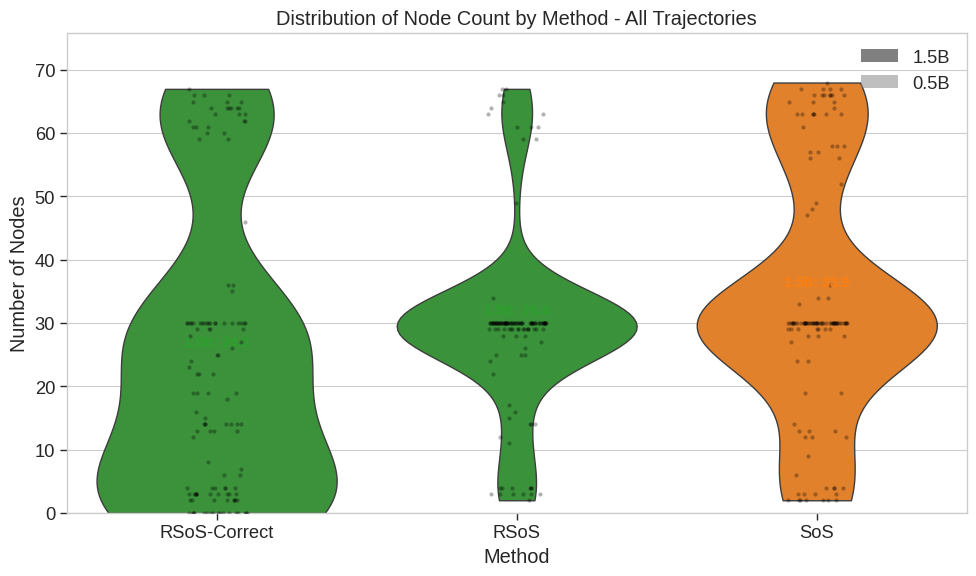

/tmp/ipykernel_903110/1031170060.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_903110/1031170060.py:56: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


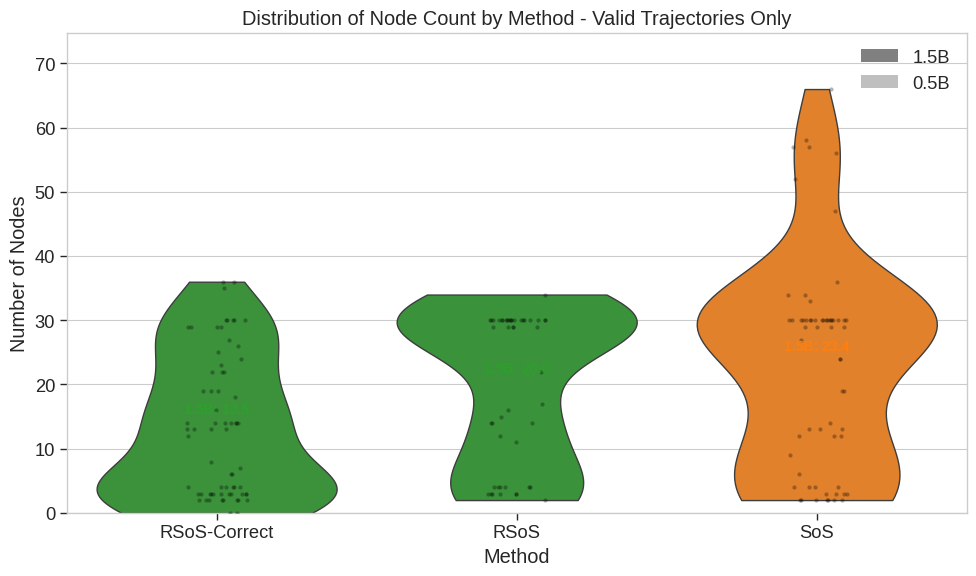

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Define your color mapping
method_colors = {
    'SoS': '#ff7f0e',       # orange
    'RSoS': '#2ca02c',      # green
    'RSoS-Correct': '#2ca12c'  # slightly different green
}

model_sizes = ['1.5B']

# Create two separate plots
for valid_only in [False, True]:
    # Filter the data
    methods_to_include = ['SoS', 'RSoS', 'RSoS-Correct']
    
    if valid_only:
        plot_df = trajectory_df[
            (trajectory_df['method'].isin(methods_to_include)) & 
            (trajectory_df['is_valid'] == True)
        ].copy()
        title_suffix = "Valid Trajectories Only"
    else:
        plot_df = trajectory_df[
            trajectory_df['method'].isin(methods_to_include)
        ].copy()
        title_suffix = "All Trajectories"
    
    # Sort by mean num_nodes
    means = plot_df.groupby('method')['num_nodes'].mean().sort_values()
    sorted_methods = means.index.tolist()
    
    # Make the figure
    plt.figure(figsize=(10, 6))
    
    # Create separate violin plots for each model size with different opacity
    for i, model_size in enumerate(model_sizes):
        # Filter for this model size
        size_df = plot_df[plot_df['model_size'] == model_size].copy()
        
        # Skip if no data for this model size
        if len(size_df) == 0:
            continue
        
        # Set opacity based on model size
        alpha = 0.5 if model_size == '0.5B' else 1.0
        
        # Create violin plot
        ax = sns.violinplot(
            x='method', 
            y='num_nodes',
            data=size_df,
            palette={m: method_colors[m] for m in sorted_methods},
            cut=0,
            scale="width", 
            inner=None,
            order=sorted_methods,
            alpha=alpha
        )
        
        # Add individual data points (optional)
        sns.stripplot(
            x='method', 
            y='num_nodes', 
            data=size_df,
            color='black',
            size=3,
            alpha=0.3,
            order=sorted_methods,
            jitter=True
        )
    
    # Add mean labels
    for method in sorted_methods:
        for model_size in model_sizes:
            subset = plot_df[(plot_df['method'] == method) & (plot_df['model_size'] == model_size)]
            if len(subset) > 0:
                mean_val = subset['num_nodes'].mean()
                # Position the label
                x_pos = sorted_methods.index(method)
                alpha = 0.5 if model_size == '0.5B' else 1.0
                plt.text(
                    x_pos, 
                    mean_val + 2,  # Position slightly above the mean
                    f"{model_size}: {mean_val:.1f}",
                    ha='center', 
                    color=method_colors[method],
                    alpha=alpha,
                    fontweight='bold',
                    fontsize=10
                )
    
    # Add titles and labels
    plt.title(f'Distribution of Node Count by Method - {title_suffix}')
    plt.xlabel('Method')
    plt.ylabel('Number of Nodes')
    plt.ylim(0, plot_df['num_nodes'].max() * 1.1)  # Add some space at the top
    
    # Add legend for model sizes
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='1.5B'),
        Patch(facecolor='gray', alpha=0.5, label='0.5B')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    
    # Save the figure
    filename = f"images/node_distribution_{'valid_only' if valid_only else 'all'}.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.pdf', '.png'), format='png', dpi=150, bbox_inches='tight')
    
    plt.show()

In [109]:
def print_trajectories_by_failure_type_from_df(trajectories_df, file_path=None, failure_type=None, model_size=None, dataset_type=None, dataset_size=None, context_length=None, limit=5):
    """
    Print trajectories that match specified criteria using the pre-processed DataFrame.
    
    Args:
        trajectories_df (pd.DataFrame): DataFrame containing processed trajectories
        file_path (str, optional): Path to specific file to filter by
        failure_type (str, optional): Type of failure to filter by
        model_size (str, optional): Model size to filter by (e.g., "0.5B")
        dataset_type (str, optional): Dataset type to filter by (e.g., "search")
        limit (int, optional): Maximum number of trajectories to print
    """
    # Start with the full DataFrame
    filtered_df = trajectories_df.copy()
    
    # Apply filters
    if file_path:
        filtered_df = filtered_df[filtered_df["file_path"] == file_path]
    
    if model_size:
        filtered_df = filtered_df[filtered_df["model_size"] == model_size]
        
    if dataset_type:
        filtered_df = filtered_df[filtered_df["dataset_type"] == dataset_type]
        
    if dataset_size:
        filtered_df = filtered_df[filtered_df["dataset_size"] == dataset_size]
    
    if failure_type:
        if failure_type == "arithmetic_error":
            filtered_df = filtered_df[filtered_df["arithmetic_error"]]
        elif failure_type == "invalid_number":
            filtered_df = filtered_df[filtered_df["invalid_number_usage"]]
        elif failure_type == "mismatched_target":
            filtered_df = filtered_df[filtered_df["mismatched_target"]]
        elif failure_type == "incomplete":
            # Get max token count for each file
            file_max_tokens = filtered_df.groupby("file_path")["token_count"].max().to_dict()
            # Filter trajectories that hit max tokens and have formatting issues
            filtered_df = filtered_df[
                filtered_df.apply(
                    lambda row: row["formatting_issues"] and np.isclose(row["token_count"],file_max_tokens[row["file_path"]],rtol=1e-2), 
                    axis=1
                )
            ]
        elif failure_type == "formatting_issues":
            file_max_tokens = filtered_df.groupby("file_path")["token_count"].max().to_dict()
            filtered_df = filtered_df[
                filtered_df.apply(
                    lambda row: row["formatting_issues"] and (np.isclose(row["token_count"],file_max_tokens[row["file_path"]],rtol=1e-2) == False), 
                    axis=1
                )
            ]
        elif failure_type == "valid":
            filtered_df = filtered_df[filtered_df["is_valid"]]
        else:
            print(f"Unknown failure type: {failure_type}")
            return
    
    # Print results
    print(f"Found {len(filtered_df)} trajectories matching criteria")
    
    for i, (_, traj) in enumerate(filtered_df.head(limit).iterrows()):
        print(f"\n--- Trajectory {traj['trajectory_index']} ---")
        print(f"Model: {traj['model_size']} {traj['dataset_type']} {traj['context_length']} {traj['dataset_size']}")
        print(f"Problem: {traj['nums']}")
        print(f"Target: {traj['target']}")
        print(f"Token count: {traj['token_count']}")
        
        if traj.get("arithmetic_error"):
            print(f"Arithmetic errors: {traj['arithmetic_error_count']} out of {traj['total_equations']} equations")
            print(f"Sign errors: {traj.get('sign_errors', 0)} out of {traj['arithmetic_error_count']} arithmetic errors")
        
        if traj.get("heuristic_calculation_count", 0) > 0:
            print(f"Heuristic calculations: {traj['heuristic_calculation_count']}")
            print(f"Heuristic calculation errors: {traj.get('heuristic_arithmetic_errors', 0)}")
        
        if traj.get("node_recall_errors", 0) > 0:
            print(f"Node recall errors: {traj['node_recall_errors']}")
        
        print("\nCompletion:")
        # preamble_pattern = r"system\nYou are Qwen.*?RESULT: final_value\n```\n\nsystem\n"
        # cleaned_completion = re.sub(preamble_pattern, "", traj['completion'], flags=re.DOTALL).strip()
        cleaned_completion = traj['completion']
        print(cleaned_completion)
    
    if len(filtered_df) > limit:
        print(f"\n... {len(filtered_df) - limit} more trajectories not shown")

# Example usage:
# trajectory_df, stats_df = process_json_files("path/to/experiments")
# print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="0.5B")

In [110]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="1.5B", dataset_type="optimal", dataset_size="5k", limit=10)

Found 32 trajectories matching criteria

--- Trajectory 1 ---
Model: 1.5B optimal 8k 5k
Problem: [9, 62, 67, 5]
Target: 20
Token count: 591
Arithmetic errors: 4 out of 15 equations
Sign errors: 0 out of 4 arithmetic errors

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [9, 62, 67, 5] using only arithmetic operations (+, -, *, /) to reach the target value 20. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```


assistant
Current State: 20:[9, 62, 67, 5], Operations: []
Exploring Operation: 9*67=603, Resulting Numbers: [62, 5, 603]
Generated Node #2: [62, 5, 603] from Operation: 9*67=603
Current State: 20:[62, 5, 603], Operations: ['9*67=603']
Exploring Opera

In [111]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="formatting_issues", model_size="0.5B", dataset_type="search-react-correct", dataset_size="5k", limit=10)

Found 212 trajectories matching criteria

--- Trajectory 0 ---
Model: 0.5B search-react-correct 10k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 157

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
SOLUTION: NO
OPERATIONS: [] 
RESULT: None

--- Trajectory 1 ---
Model: 0.5B search-react-correct 10k 5k
Problem: [9, 62, 67, 5]
Target: 20
Token count: 155

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [9, 62, 67, 5] using only 

In [112]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="mismatched_target", model_size="1.5B", dataset_type="search-react", limit=2)

Found 16 trajectories matching criteria

--- Trajectory 1 ---
Model: 1.5B search-react 8k 5k
Problem: [9, 62, 67, 5]
Target: 20
Token count: 5780
Heuristic calculations: 30
Heuristic calculation errors: 30

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [9, 62, 67, 5] using only arithmetic operations (+, -, *, /) to reach the target value 20. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```


assistant
We have these numbers [9, 62, 67, 5]. Our goal is to produce 20. Let's show the search process step by step:
One possible strategy is to use a Breadth-First Search (BFS) with Beam Size 5 guided by a **sum-based** heuristic, which computes the average of the 

In [113]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="formatting_issues", model_size="1.5B", dataset_size="5k", dataset_type="deepseek", limit=10)

Found 0 trajectories matching criteria


In [114]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="incomplete", model_size="1.5B", dataset_type="search", dataset_size="5k", limit=1)

Found 50 trajectories matching criteria

--- Trajectory 0 ---
Model: 1.5B search 8k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 8333

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
Current State: 64:[53, 57, 13, 48], Operations: []
Exploring Operation: 57-13=44, Resulting Numbers: [53, 48, 44]
Generated Node #0,0: 64:[53, 48, 44] Operation: 57-13=44
Exploring Operation: 53+48=101, Resulting Numbers: [13, 49, 101]
Generated Node #0,1: 64:[13, 49, 101] Operation: 53+48=101
Exploring Operation: 53+13